# Deep Learning : Assignment 1 
## Vadim Benichou 
### Master Data Sciences & Business Analytics

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.utils import to_categorical
import matplotlib.cm as cm
from keras import optimizers
import keras
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [ ]:
# On some implementations of matplotlib
IMAGE_SIZE = 72

# 2) Getting Started

In [2]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


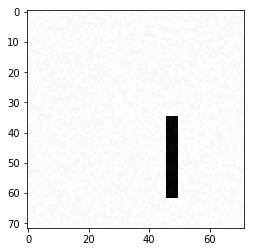

In [3]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

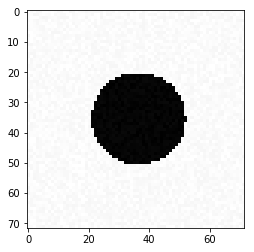

In [4]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

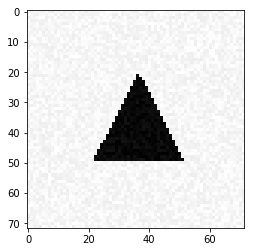

In [5]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

# 3) Simple Classification

In [153]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [154]:
X_train.shape,Y_train.shape

((300, 5184), (300,))

In [155]:
Y_traink = keras.utils.to_categorical(Y_train, 3)
Y_traink.shape

(300, 3)

In [156]:
n_cols=X_train.shape[1]
n_cols

5184

### Stochastic gradient descent optimizer

In [157]:
model1=Sequential()

In [158]:
model1.add(Dense(units=32,kernel_initializer= 'uniform',input_dim=n_cols ,activation="relu"))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=10,kernel_initializer= 'uniform',activation="relu"))
model1.add(Dropout(rate=0.2))
model1.add(Dense(units=3,kernel_initializer= 'uniform',activation="softmax"))

In [159]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model1.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [160]:
model1.fit(X_train, Y_train, epochs=60, batch_size=32)

Epoch 1/60
300/300 [==============================] - 1s 3ms/step - loss: 0.6918 - acc: 0.3100
Epoch 2/60
300/300 [==============================] - 0s 128us/step - loss: 0.6904 - acc: 0.3100
Epoch 3/60
300/300 [==============================] - 0s 141us/step - loss: 0.6922 - acc: 0.3100
Epoch 4/60
300/300 [==============================] - 0s 142us/step - loss: 0.6930 - acc: 0.3100
Epoch 5/60
300/300 [==============================] - 0s 167us/step - loss: 0.6923 - acc: 0.3100
Epoch 6/60
300/300 [==============================] - 0s 144us/step - loss: 0.6901 - acc: 0.3100
Epoch 7/60
300/300 [==============================] - 0s 137us/step - loss: 0.6910 - acc: 0.3100
Epoch 8/60
300/300 [==============================] - 0s 129us/step - loss: 0.6918 - acc: 0.3100
Epoch 9/60
300/300 [==============================] - 0s 122us/step - loss: 0.6921 - acc: 0.3100
Epoch 10/60
300/300 [==============================] - 0s 118us/step - loss: 0.6906 - acc: 0.3100
Epoch 11/60
300/300 [==========

Evaluate the model : 

In [161]:
scores = model1.evaluate(X_train, Y_train)
scores

300/300 [==============================] - 0s 1ms/step


[0.6899419601758321, 0.3100000003973643]

Testing the model on a disk :

In [162]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model1.predict(X_test)

array([[1.0018418]], dtype=float32)

### Adam optimizer

In [179]:
model2 = Sequential()
model2.add(Dense(3,kernel_initializer= 'uniform', activation='softmax',input_dim=n_cols))

In [180]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, Y_traink,batch_size=32,epochs=25)

Epoch 1/25
300/300 [==============================] - 1s 4ms/step - loss: 2.2863 - acc: 0.3900
Epoch 2/25
300/300 [==============================] - 0s 120us/step - loss: 0.8088 - acc: 0.6467
Epoch 3/25
300/300 [==============================] - 0s 139us/step - loss: 0.5766 - acc: 0.7400
Epoch 4/25
300/300 [==============================] - 0s 132us/step - loss: 0.4079 - acc: 0.8733
Epoch 5/25
300/300 [==============================] - 0s 141us/step - loss: 0.3807 - acc: 0.8267
Epoch 6/25
300/300 [==============================] - 0s 141us/step - loss: 0.3227 - acc: 0.8633
Epoch 7/25
300/300 [==============================] - 0s 137us/step - loss: 0.2668 - acc: 0.9100
Epoch 8/25
300/300 [==============================] - 0s 136us/step - loss: 0.2848 - acc: 0.8733
Epoch 9/25
300/300 [==============================] - 0s 135us/step - loss: 0.3086 - acc: 0.8500
Epoch 10/25
300/300 [==============================] - 0s 125us/step - loss: 0.2510 - acc: 0.8900
Epoch 11/25
300/300 [==========

Testing the model on a disk

In [181]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
model2.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

## 4) Visualization of the solution

#### Visualization for Stochastic gradient descent optimizer

In [163]:
Viz1=model1.get_weights()[0]

In [164]:
im1 = Viz1[:,0]
im2 = Viz1[:,1]
im3 = Viz1[:,2]

In [165]:
im1.shape,im2.shape,im3.shape

((5184,), (5184,), (5184,))

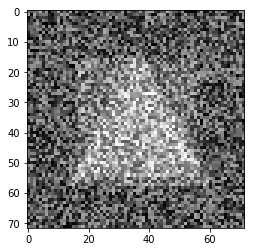

In [166]:
%matplotlib inline 
plt.imshow(im1.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

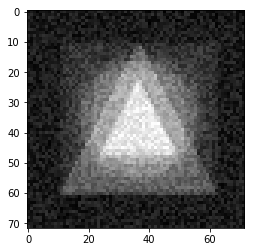

In [167]:
%matplotlib inline 
plt.imshow(im2.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

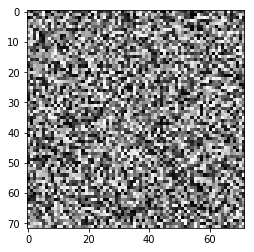

In [168]:
plt.imshow(im3.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

#### Visualization for Adam optimizer

In [182]:
Viz2=model2.get_weights()[0]

In [183]:
im1 = Viz2[:,0]
im2 = Viz2[:,1]
im3 = Viz2[:,2]

In [184]:
im1.shape,im2.shape,im3.shape

((5184,), (5184,), (5184,))

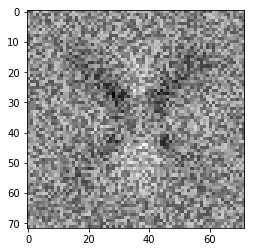

In [185]:
%matplotlib inline 
plt.imshow(im1.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

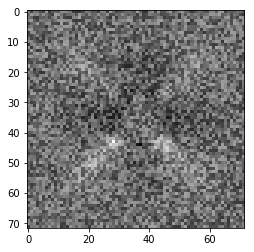

In [186]:
%matplotlib inline 
plt.imshow(im2.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

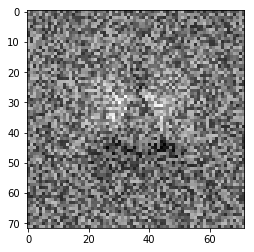

In [187]:
plt.imshow(im3.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

## 5) A more difficult classification problem

New training set

In [200]:
[X_train2, Y_train2] = generate_dataset_classification(300, 20, True)
Y_train2k = keras.utils.to_categorical(Y_train2, 3)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [201]:
target_train=to_categorical(Y_train2k)

Creating a model with SGD optimizer

In [202]:
model3= Sequential()
model3.add(Dense(16, input_dim=5184, activation='relu'))
model3.add(Dense(3))


In [203]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model3.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [204]:
model3.fit(X_train2, Y_train2k,batch_size=16,epochs=150,verbose=False)

Generate a test set :

In [205]:
[X_test2, Y_test2] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Evaluating the model :

In [206]:
model3.evaluate(X_test2, Y_test2)

300/300 [==============================] - 0s 2ms/step


[0.22403119802474974, 0.33]

Reshape X_train 

In [207]:
X_train2 = X_train2.reshape(X_train2.shape[0],72,72,1)

Convolutional model

In [208]:
model4 = Sequential()
model4.add(Conv2D(16,kernel_size=(5, 5), activation='relu',input_shape=(72, 72, 1)))
model4.add(MaxPooling2D(pool_size=(2, 2))) 
model4.add(Flatten())
model4.add(Dense(100,activation='relu'))
model4.add(Dense(3,activation='sigmoid'))

In [209]:
sgd = SGD(lr=0.01,decay=1e-6, momentum=0.9,nesterov=True)
model4.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

In [210]:
model4.fit(X_train2,Y_train2k, batch_size=16, epochs=15)

Epoch 1/15
300/300 [==============================] - 3s 11ms/step - loss: 0.2264 - acc: 0.3900
Epoch 2/15
300/300 [==============================] - 1s 4ms/step - loss: 0.2170 - acc: 0.4867
Epoch 3/15
300/300 [==============================] - 1s 5ms/step - loss: 0.2121 - acc: 0.4400
Epoch 4/15
300/300 [==============================] - 2s 5ms/step - loss: 0.2052 - acc: 0.5333
Epoch 5/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1948 - acc: 0.5867
Epoch 6/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1818 - acc: 0.5933
Epoch 7/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1749 - acc: 0.5867
Epoch 8/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1652 - acc: 0.6567
Epoch 9/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1545 - acc: 0.6600
Epoch 10/15
300/300 [==============================] - 1s 5ms/step - loss: 0.1459 - acc: 0.6833
Epoch 11/15
300/300 [===========================

In [211]:
[X_test3, Y_test3] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [214]:
model4.evaluate(X_train2,Y_train2k)

300/300 [==============================] - 1s 2ms/step


[0.11573171863953273, 0.7700000007947286]

In [215]:
print('The loss is : {0}'.format(model4.evaluate(X_test3.reshape(X_test3.shape[0],72,72,1),Y_test3)[0]))

300/300 [==============================] - 1s 2ms/step
The loss is : 0.15235363950332007


# 6) A Regression Problem

New training set

In [216]:
[X_train4, Y_train4] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Visualize a sample

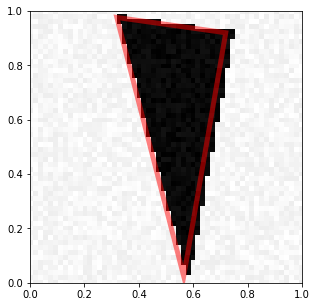

[[0.71986584 0.92000602]
 [0.31926686 0.97619732]
 [0.56522072 0.02423682]]


In [217]:
visualize_prediction(X_train4[0], Y_train4[0])
print(Y_train4[0].reshape(3,2))

In [218]:
[X_reg, Y_reg] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [219]:
regressor = Sequential()

In [220]:
regressor.add(Dense(units=128,kernel_initializer= 'uniform',activation="relu", input_dim=n_cols))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=128,kernel_initializer= 'uniform',activation="relu"))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=6,kernel_initializer= 'uniform'))

In [221]:
regressor.compile(optimizer="adam", loss='mse', metrics= ["mse"])
history=regressor.fit(X_train4,Y_train4,validation_data=(X_reg,Y_reg),batch_size=32, epochs=300)

Train on 300 samples, validate on 300 samples
Epoch 1/300
300/300 [==============================] - 2s 7ms/step - loss: 0.1824 - mean_squared_error: 0.1824 - val_loss: 0.0952 - val_mean_squared_error: 0.0952
Epoch 2/300
300/300 [==============================] - 0s 667us/step - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.0842 - val_mean_squared_error: 0.0842
Epoch 3/300
300/300 [==============================] - 0s 697us/step - loss: 0.1036 - mean_squared_error: 0.1036 - val_loss: 0.0862 - val_mean_squared_error: 0.0862
Epoch 4/300
300/300 [==============================] - 0s 733us/step - loss: 0.0958 - mean_squared_error: 0.0958 - val_loss: 0.0769 - val_mean_squared_error: 0.0769
Epoch 5/300
300/300 [==============================] - 0s 673us/step - loss: 0.0950 - mean_squared_error: 0.0950 - val_loss: 0.0771 - val_mean_squared_error: 0.0771
Epoch 6/300
300/300 [==============================] - 0s 752us/step - loss: 0.0911 - mean_squared_error: 0.0911 - val_loss: 0.0791

Epoch 50/300
300/300 [==============================] - 0s 756us/step - loss: 0.0749 - mean_squared_error: 0.0749 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 51/300
300/300 [==============================] - 0s 780us/step - loss: 0.0738 - mean_squared_error: 0.0738 - val_loss: 0.0772 - val_mean_squared_error: 0.0772
Epoch 52/300
300/300 [==============================] - 0s 776us/step - loss: 0.0747 - mean_squared_error: 0.0747 - val_loss: 0.0752 - val_mean_squared_error: 0.0752
Epoch 53/300
300/300 [==============================] - 0s 746us/step - loss: 0.0768 - mean_squared_error: 0.0768 - val_loss: 0.0757 - val_mean_squared_error: 0.0757
Epoch 54/300
300/300 [==============================] - 0s 804us/step - loss: 0.0732 - mean_squared_error: 0.0732 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 55/300
300/300 [==============================] - 0s 734us/step - loss: 0.0730 - mean_squared_error: 0.0730 - val_loss: 0.0779 - val_mean_squared_error: 0.0779
Epoc

300/300 [==============================] - 0s 731us/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0730 - val_mean_squared_error: 0.0730
Epoch 100/300
300/300 [==============================] - 0s 719us/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
Epoch 101/300
300/300 [==============================] - 0s 732us/step - loss: 0.0727 - mean_squared_error: 0.0727 - val_loss: 0.0750 - val_mean_squared_error: 0.0750
Epoch 102/300
300/300 [==============================] - 0s 743us/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0705 - val_mean_squared_error: 0.0705
Epoch 103/300
300/300 [==============================] - 0s 718us/step - loss: 0.0726 - mean_squared_error: 0.0726 - val_loss: 0.0716 - val_mean_squared_error: 0.0716
Epoch 104/300
300/300 [==============================] - 0s 704us/step - loss: 0.0725 - mean_squared_error: 0.0725 - val_loss: 0.0690 - val_mean_squared_error: 0.0690
Epoch 105/30

300/300 [==============================] - 0s 707us/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.0709 - val_mean_squared_error: 0.0709
Epoch 149/300
300/300 [==============================] - 0s 710us/step - loss: 0.0723 - mean_squared_error: 0.0723 - val_loss: 0.0698 - val_mean_squared_error: 0.0698
Epoch 150/300
300/300 [==============================] - 0s 691us/step - loss: 0.0691 - mean_squared_error: 0.0691 - val_loss: 0.0691 - val_mean_squared_error: 0.0691
Epoch 151/300
300/300 [==============================] - 0s 694us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0719 - val_mean_squared_error: 0.0719
Epoch 152/300
300/300 [==============================] - 0s 707us/step - loss: 0.0700 - mean_squared_error: 0.0700 - val_loss: 0.0705 - val_mean_squared_error: 0.0705
Epoch 153/300
300/300 [==============================] - 0s 715us/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0697 - val_mean_squared_error: 0.0697
Epoch 154/30

300/300 [==============================] - 0s 695us/step - loss: 0.0705 - mean_squared_error: 0.0705 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 198/300
300/300 [==============================] - 0s 707us/step - loss: 0.0710 - mean_squared_error: 0.0710 - val_loss: 0.0748 - val_mean_squared_error: 0.0748
Epoch 199/300
300/300 [==============================] - 0s 653us/step - loss: 0.0688 - mean_squared_error: 0.0688 - val_loss: 0.0693 - val_mean_squared_error: 0.0693
Epoch 200/300
300/300 [==============================] - 0s 715us/step - loss: 0.0690 - mean_squared_error: 0.0690 - val_loss: 0.0709 - val_mean_squared_error: 0.0709
Epoch 201/300
300/300 [==============================] - 0s 730us/step - loss: 0.0711 - mean_squared_error: 0.0711 - val_loss: 0.0738 - val_mean_squared_error: 0.0738
Epoch 202/300
300/300 [==============================] - 0s 676us/step - loss: 0.0736 - mean_squared_error: 0.0736 - val_loss: 0.0729 - val_mean_squared_error: 0.0729
Epoch 203/30

300/300 [==============================] - 0s 733us/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 247/300
300/300 [==============================] - 0s 724us/step - loss: 0.0673 - mean_squared_error: 0.0673 - val_loss: 0.0727 - val_mean_squared_error: 0.0727
Epoch 248/300
300/300 [==============================] - 0s 667us/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0729 - val_mean_squared_error: 0.0729
Epoch 249/300
300/300 [==============================] - 0s 715us/step - loss: 0.0679 - mean_squared_error: 0.0679 - val_loss: 0.0735 - val_mean_squared_error: 0.0735
Epoch 250/300
300/300 [==============================] - 0s 681us/step - loss: 0.0689 - mean_squared_error: 0.0689 - val_loss: 0.0696 - val_mean_squared_error: 0.0696
Epoch 251/300
300/300 [==============================] - 0s 716us/step - loss: 0.0706 - mean_squared_error: 0.0706 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 252/30

300/300 [==============================] - 0s 703us/step - loss: 0.0685 - mean_squared_error: 0.0685 - val_loss: 0.0722 - val_mean_squared_error: 0.0722
Epoch 296/300
300/300 [==============================] - 0s 675us/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0695 - val_mean_squared_error: 0.0695
Epoch 297/300
300/300 [==============================] - 0s 661us/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0712 - val_mean_squared_error: 0.0712
Epoch 298/300
300/300 [==============================] - 0s 714us/step - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 0.0704 - val_mean_squared_error: 0.0704
Epoch 299/300
300/300 [==============================] - 0s 703us/step - loss: 0.0665 - mean_squared_error: 0.0665 - val_loss: 0.0735 - val_mean_squared_error: 0.0735
Epoch 300/300
300/300 [==============================] - 0s 704us/step - loss: 0.0658 - mean_squared_error: 0.0658 - val_loss: 0.0755 - val_mean_squared_error: 0.0755


Plot of the MSE 

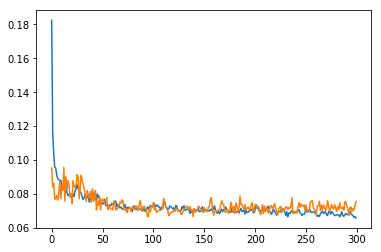

In [222]:
plt.plot(history.history["mean_squared_error"])
plt.plot(history.history["val_mean_squared_error"])

In [223]:
[X_test4, Y_test4] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [224]:
Y_pred4=regressor.predict(X_test4)

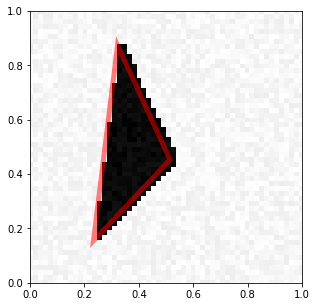

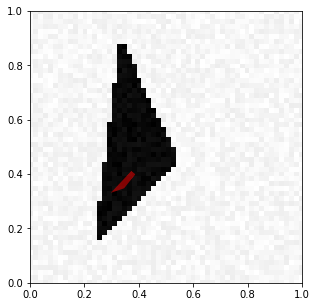

In [225]:
visualize_prediction(X_test4[2], Y_test4[2])
visualize_prediction(X_test4[2], Y_pred4[2])

In [226]:
X_Train = X_train4.reshape([-1, 72,72,1])
X_Val = X_reg.reshape([-1, 72,72,1])

In [227]:
CNN_regressor = Sequential()

In [228]:
CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,),padding="same", activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))

CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))

CNN_regressor.add(Conv2D(256,(3,3),input_shape=(72,72,1,), padding="same",activation='relu'))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(MaxPooling2D(pool_size=(2,2)))

CNN_regressor.add(Flatten())
CNN_regressor.add(Dense(units=64, kernel_initializer="uniform", activation="relu"))
CNN_regressor.add(BatchNormalization())
CNN_regressor.add(Dense(units=6, kernel_initializer="uniform"))
CNN_regressor.compile(loss='mse', optimizer='adam', metrics= ["mse"])

history=CNN_regressor.fit(X_Train,Y_train4,batch_size=32, validation_data=(X_Val, Y_reg),epochs=20)

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 113s 376ms/step - loss: 0.3355 - mean_squared_error: 0.3355 - val_loss: 0.3935 - val_mean_squared_error: 0.3935
Epoch 2/20
300/300 [==============================] - 106s 353ms/step - loss: 0.2809 - mean_squared_error: 0.2809 - val_loss: 0.4931 - val_mean_squared_error: 0.4931
Epoch 3/20
300/300 [==============================] - 96s 319ms/step - loss: 0.2573 - mean_squared_error: 0.2573 - val_loss: 0.2797 - val_mean_squared_error: 0.2797
Epoch 4/20
300/300 [==============================] - 96s 320ms/step - loss: 0.2327 - mean_squared_error: 0.2327 - val_loss: 0.2401 - val_mean_squared_error: 0.2401
Epoch 5/20
300/300 [==============================] - 96s 319ms/step - loss: 0.2052 - mean_squared_error: 0.2052 - val_loss: 0.1908 - val_mean_squared_error: 0.1908
Epoch 6/20
300/300 [==============================] - 96s 319ms/step - loss: 0.1720 - mean_squared_error: 0.1720 - val_loss: 0.

In [229]:
X_Test = X_test4.reshape([-1, 72,72,1])

In [230]:
Y_pred=CNN_regressor.predict(X_Test)

#### Plot of a sample of the test set and its prediction

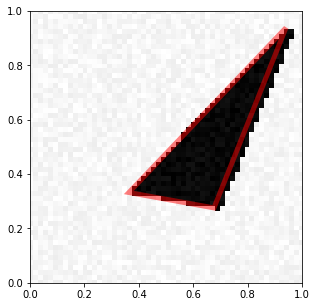

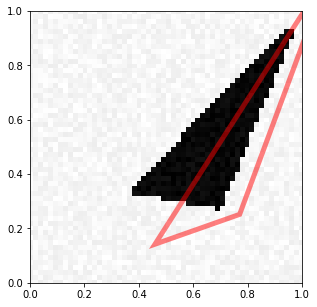

In [232]:
visualize_prediction(X_test4[0], Y_test4[0])
visualize_prediction(X_test4[0], Y_pred[0])

# 7) Image Denoising 

#### New functions

In [114]:
def generate_a_drawing2(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize, figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0, figsize)
    ax.set_ylim(0, figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[
        ::3].astype(np.float32)
    imdatan = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdatan, imdata

In [115]:
def generate_a_triangle2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random()) * figsize / 2
        middle = figsize / 2
        U = (middle, middle + size, middle - size)
        V = (middle + size, middle - size, middle - size)
    imdatan, imdata = generate_a_drawing2(figsize, U, V, noise)
    return [imdatan,imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [116]:
def generate_a_rectangle2(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize / 2 + side / 2
        bottom = figsize / 2 - side / 2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing2(figsize, U, V, noise)

In [117]:
def generate_a_disk2(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize / 2, figsize / 2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize / 2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2 * np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing2(figsize, U, V, noise)

In [118]:
def generate_dataset_2(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle2()[0].shape[0]
    X = np.zeros([nb_samples, im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle2(noise, free_location)
        elif category == 1:
            X[i],Y[i] = generate_a_disk2(noise, free_location)
        else:
            [X[i],Y[i], V] = generate_a_triangle2(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y/255
    return [X, Y]

New train set

In [119]:
[X_train5,Y_train5]=generate_dataset_2(500,20,True)

Creating data:
0
100
200
300
400


Plot of a sample of the train set

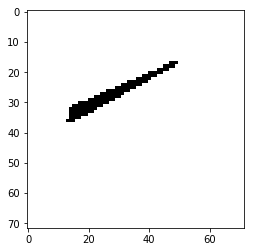

In [142]:
plt.imshow(Y_train5[300].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

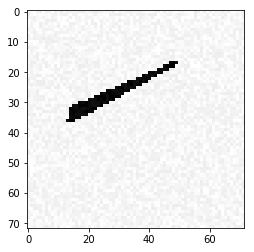

In [143]:
plt.imshow(X_train5[300].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

In [144]:
X_train6 = X_train5.reshape(X_train5.shape[0],72,72,1)
Y_train6 = Y_train5.reshape(Y_train5.shape[0],72,72,1)

In [145]:
model6 = Sequential()

model6.add(Conv2D(32,(3, 3), activation='relu',padding = 'same' ,input_shape=(72,72,1)))
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(Conv2D(32,(3,3), activation = 'relu', padding = 'same'))
model6.add(MaxPooling2D(pool_size=(2,2)))

model6.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model6.add(UpSampling2D(size=(2, 2)))
model6.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding = 'same'))
model6.add(UpSampling2D(size=(2, 2)))
model6.add(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding = 'same'))

In [147]:
model6.compile(optimizer='adadelta',loss='binary_crossentropy',metrics=['accuracy'])
model6.fit(X_train6, Y_train6, epochs=10, batch_size=64)

Epoch 1/10
500/500 [==============================] - 13s 25ms/step - loss: 0.4163 - acc: 0.8134
Epoch 2/10
500/500 [==============================] - 10s 19ms/step - loss: 0.2106 - acc: 0.9057
Epoch 3/10
500/500 [==============================] - 10s 20ms/step - loss: 0.1786 - acc: 0.9362
Epoch 4/10
500/500 [==============================] - 10s 21ms/step - loss: 0.1276 - acc: 0.9664
Epoch 5/10
500/500 [==============================] - 10s 20ms/step - loss: 0.0639 - acc: 0.9843
Epoch 6/10
500/500 [==============================] - 10s 21ms/step - loss: 0.0473 - acc: 0.9843
Epoch 7/10
500/500 [==============================] - 9s 18ms/step - loss: 0.0419 - acc: 0.9851
Epoch 8/10
500/500 [==============================] - 10s 20ms/step - loss: 0.0415 - acc: 0.9849
Epoch 9/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0349 - acc: 0.9872
Epoch 10/10
500/500 [==============================] - 8s 17ms/step - loss: 0.0383 - acc: 0.9857


In [148]:
Xim = X_train6[9]
Xim = Xim.reshape(1,72,72,1)

In [149]:
prediction=model6.predict(Xim)

In [150]:
prediction=prediction.reshape(72,72)

Plot of its prediction

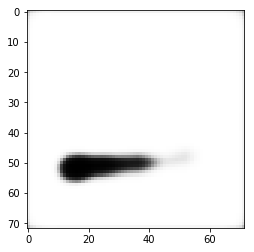

In [151]:
plt.imshow(prediction, cmap='gray')